# Using Astropy Regions to Check Margin Cache

## Intro
This notebook serves as part 2 for my work on margin caching and contains some practical examples of building margin bounding boxes using astropy's [regions](https://astropy-regions.readthedocs.io/en/stable/) and checking them against actual gaia data.

You can read 'part 1' [here](https://github.com/maxwest-uw/notebooks/blob/main/margin_cache_affine.ipynb). That notebook contains the full explanation of how the affine transform to create the bounding box, which is presented here without much comment.

In [1]:
import healpy as hp
import numpy as np
import sys
sys.path.insert(0, '/astro/users/maxwest/lsd2')
import hipscat as hc

In [2]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from regions import PixCoord, PolygonSkyRegion, PolygonPixelRegion
import astropy.wcs as wcs

In [3]:
margin_thresh = 0.1 # in degrees
k = 3
pix = 4
step = 100

## Affine Transform

In [4]:
resolution = hp.nside2resol(2**k, arcmin=True) / 60.
resolution_and_thresh = resolution + (margin_thresh)
margin_area = resolution_and_thresh ** 2
pixel_area = hp.pixelfunc.nside2pixarea(2**k, degrees=True)
scale = margin_area / pixel_area
scale

1.0274748806654526

In [5]:
pixel_boundaries = hp.vec2dir(hp.boundaries(2**k, pix, step=step, nest=True), lonlat=True)

n_samples = len(pixel_boundaries[0])
centroid_lon = np.sum(pixel_boundaries[0]) / n_samples
centroid_lat = np.sum(pixel_boundaries[1]) / n_samples
translate_lon = centroid_lon - (centroid_lon * scale)
translate_lat = centroid_lat - (centroid_lat * scale)
translate_lon, translate_lat

(-1.5454620374317045, -0.3982716101184458)

In [6]:
affine_matrix = np.array([[scale, 0, translate_lon],
                              [0, scale, translate_lat],
                              [0,     0,             1]])

homogeneous = np.ones((3, n_samples))
homogeneous[0] = pixel_boundaries[0]
homogeneous[1] = pixel_boundaries[1]

transformed_bounding_box = np.matmul(affine_matrix, homogeneous)
transformed_bounding_box

array([[56.25      , 56.19220454, 56.13440908, ..., 56.42338639,
        56.36559092, 56.30779546],
       [19.60791849, 19.55589241, 19.50388254, ..., 19.45188882,
        19.50388254, 19.55589241],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

## Checking Our Bounding Box On-Sky
Having a nicely transformed transformed set of coordinates is nifty, but unfortunately we do have to actually check real life coordinates against it somehow. This would be easier if healpixels were nice, regular polygons, but unfortunately they're quite squiqly, so we're going to have to find a way to build polygons on the sky.

Luckily for us, astropy has been developing the [`regions`](https://github.com/astropy/regions) package which does just that! At the time of writing this notebook, they're on `v0.7` currently and they do say that the package is still under development.

While `regions` does have a basic `PolygonSkyRegion` class to easily create shapes based on `SkyCoord` coordinates, the package currently currently does have any bound checking for that class directly, so we'll have to convert that shape into a `PolygonPixelRegion` and convert all of our coordinates into a common pixel space, which we can do by creating a WCS object based on the healpixel that we're trying to check.

### Building the WCS
Let's keep it simple by setting the origin for our pixel space at the minima for `ra` and `dec` of our healpixel. By assuming that our "image" is oriented upwards, we can use a `cdelt` value of 1 arcsecond for both the ra and dec.

It's possible that trying to create cartesian coordinate planes for spherical points might cause enough error to warrant concern (especially at larger order pixel) but from my experimentation everything seems to work quite well.

In [7]:
min_ra = np.min(transformed_bounding_box[0])
max_ra = np.max(transformed_bounding_box[0])
min_dec = np.min(transformed_bounding_box[1])
max_dec = np.max(transformed_bounding_box[1])

pix_size = 0.0002777777778

In [8]:
min_ra, min_dec

(50.470453796256834, 9.459392496371214)

In [9]:
ra_naxis =int((max_ra - min_ra) / pix_size)
dec_naxis = int((max_dec - min_dec) / pix_size)
ra_naxis, dec_naxis

(41612, 36534)

In [10]:
wcs_margin = wcs.WCS(naxis=2)
wcs_margin.wcs.crpix = [1, 1]
wcs_margin.wcs.crval = [min_ra, min_dec]
wcs_margin.wcs.cunit = ["deg", "deg"]
wcs_margin.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs_margin.wcs.cdelt = [pix_size, pix_size]
wcs_margin.array_shape = [ra_naxis, dec_naxis]

### `Regions` Bounding Box
Now that we have our WCS constructed, we can build our bounding box!

For `k` of less than 2, the large size of the healpixels causes `regions` and wcs calculations to break down (not to mention, creates a large amount of error in calculating bounds) so to solve this we break the bounding box into 4 different polygons and create a new WCS for each. For higher orders, we can just work with building a single bounding box.

In [11]:
polygons = []
if k < 2:
    for i in range(4):    
        j = i * step
        lon = list(transformed_bounding_box[0][j:j+step+1])
        lat = list(transformed_bounding_box[1][j:j+step+1])

        lon.append(centroid_lon)
        lat.append(centroid_lat)

        wcs_sub = wcs.WCS(naxis=2)
        wcs_sub.wcs.crpix = [1, 1]
        wcs_sub.wcs.crval = [lon[0], lat[0]]
        wcs_sub.wcs.cunit = ["deg", "deg"]
        wcs_sub.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        wcs_sub.wcs.cdelt = [pix_size, pix_size]
        wcs_sub.array_shape = [int(ra_naxis/2), int(dec_naxis/2)]

        vertices = SkyCoord(lon, lat, unit='deg')
        sky_region = PolygonSkyRegion(vertices=vertices)
        polygons.append((sky_region.to_pixel(wcs_sub), wcs_sub))
else:
    vertices = SkyCoord(transformed_bounding_box[0], transformed_bounding_box[1], unit='deg')
    sky_region = PolygonSkyRegion(vertices=vertices)
    polygon_region = sky_region.to_pixel(wcs_margin)
    polygons = [(polygon_region, wcs_margin)]

Let's sanity check some random points against our region.

In [12]:
# far out point, expect False
test_ra1 = min_ra - 8
test_dec1 = min_dec - 8

# middle of our healpixel, expect True
test_ra2 = centroid_lon
test_dec2 = centroid_lat

# actual point from Norder3/Npix4 of my
# gaia test catalog, expect True
# if k = 3 and pix = 4
test_ra3 = 50.61225197
test_dec3 = 14.4767556

test_ra = np.array([test_ra1, test_ra2, test_ra3])
test_dec = np.array([test_dec1, test_dec2, test_dec3])

sc = SkyCoord(test_ra, test_dec, unit='deg')
sc

<SkyCoord (ICRS): (ra, dec) in deg
    [(42.4704538 ,  1.4593925 ), (56.25      , 14.49584495),
     (50.61225197, 14.4767556 )]>

In [13]:
x, y = wcs_margin.world_to_pixel(sc)

pc = PixCoord(x, y)
polygons[0][0].contains(pc)

array([False,  True,  True])

looking good!! Now we're going to check it out against some actual gaia data and plot it so we can get a good visual sense of how this works.

## Running Against Actual Gaia Data
In the `hipscat` implementation of margin caching, we the pixel at a higher order `highest_k` (in our case, k=6) and find all the `highest_k` pixels that direcly border the given partition pixel. This allows us to constrain the data significantly and quickly before we do the more precise margin bound checking.

let's grab those margins now, for visualization purposes later.

In [14]:
margins = hc.margin_utils.get_margin(k, pix, 6 - k)
margins

array([   85,    93,   117,   125,    87,    95,   119,   127,   213,
         384,   388,   400,   404,   385,   389,   401,   405,   448,
         320,   328,   352,   360,   322,   330,   354,   362, 23530,
       23466, 23470, 23482, 23486, 23467, 23471, 23483, 23487, 23295])

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

%matplotlib inline

I've uploaded some of the actual results of find the data that fits within the `margins` pixels above, which was run with the `lsd2` prototype. We can use that data to do a test of our margin bound checking and take a look at it on a plot!

In [16]:
import pandas as pd

df1 = pd.read_parquet(f'/astro/users/maxwest/neighbor-{k}-{pix}.parquet')
df2 = pd.read_parquet(f'/astro/users/maxwest/catalog-{k}-{pix}.parquet')

def in_bounds(skycoord, polys):
    bound_vals = []
    for p, w in polys:
        xv, yv = wcs.utils.skycoord_to_pixel(skycoord, w)
        pcs = PixCoord(xv, yv)
        vals = p.contains(pcs)
        bound_vals.append(vals)
    return np.array(bound_vals).any(axis=0)

# convert ra and dec values into SkyCoords
scs = SkyCoord(df1['ra'].values, df1['dec'].values, unit='deg')
bound_vals = in_bounds(scs, polygons)
df1['in_margin'] = bound_vals

in_box = df1.loc[df1['in_margin'] == True]
out_box = df1.loc[df1['in_margin'] == False]

Now let's take take a peek and see what this all looks like!
- **Green**: data that's inside the margin
- **Red**: data that was in the neighboring pixels but not part of the bounding box.
- **Blue**: pixel partition catalog data

I've also plotted the bounds of the margin pixels as well as the line marking the bounding box.

(9.359392496371214, 19.707918487715578)

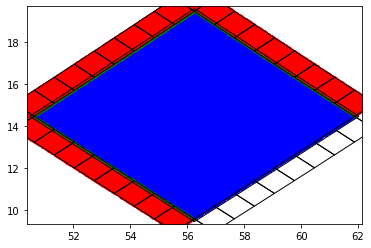

In [17]:
def plot_pixel():
    ax = plt.subplot(1, 1, 1)
    ax.scatter(df2['ra'].values, df2['dec'].values, color='blue', s=1)
    # ax.scatter(df3['ra'].values, df3['dec'].values, color='orange')
    # ax.scatter(in_constraint['ra'].values, in_constraint['dec'].values, color='orange', s=1)

    ax.scatter(in_box['ra'].values, in_box['dec'].values, color='green', s=1)
    ax.scatter(out_box['ra'].values, out_box['dec'].values, color='red', s=1)

    for m in margins:
        b = hp.vec2dir(hp.boundaries(2**6, m, nest=True), lonlat=True)
        lon = b[0]
        lat = b[1]
        vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
        p = Polygon(vertices, closed=True, edgecolor='black', facecolor='none')
        ax.add_patch(p)

    lon = transformed_bounding_box[0]
    lat = transformed_bounding_box[1]
    vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
    p = Polygon(vertices, closed=True, edgecolor='black', facecolor='none')
    ax.add_patch(p)

plot_pixel()
    
plt.xlim(min_ra - 0.1, max_ra + 0.1)
plt.ylim(min_dec - 0.1, max_dec + 0.1)

Computer, Enhance!

(14.495844948991568, 19.707918487715578)

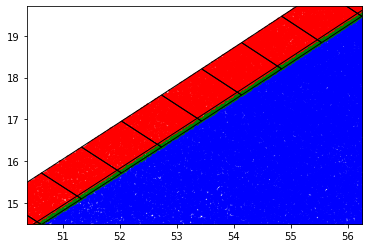

In [18]:
plot_pixel()

plt.xlim(min_ra - 0.1, centroid_lon)
plt.ylim(centroid_lat, max_dec + 0.1)

Let's see how many made it into the `neighbor.parquet` and how many didn't make the cut.

In [19]:
num_in = len(in_box)
num_out = len(out_box)
num_in, num_out

(9458, 82575)

And finally, let's take a look at the distance between the original bounding box and the transformed one. The closer this mean is to 6 arcseconds (for a `margin_thresh` of 0.1 degrees), the better!

In [20]:
dist = []
osc = SkyCoord(pixel_boundaries[0], pixel_boundaries[1], unit='deg')
tsc = SkyCoord(transformed_bounding_box[0], transformed_bounding_box[1], unit='deg')
dist = osc.separation(tsc)
np.mean(dist)

<Angle 0.11578265 deg>

:)